In [1]:
# Copyright (c) 2018 CA.  All rights reserved.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook 

# load x'07' data from filesystem into dataframe
hdf = pd.HDFStore('hdf5/logs07_only.h5')
log07 = hdf['df']

In [2]:
# I'll add two new columns for vsam and osam total io
log07['totvsamio'] = log07['vsamrio'] + log07['vsamwio'] 
log07['totosamio'] = log07['osamrio'] + log07['osamwio']

# another new columns will tell either this is an osam or vsam, some will be none
# numbers 0,1,2,3 are for future calculations
log07['access'] = 0      
log07.loc[log07['totvsamio'] > 0, 'access'] = 1
log07.loc[log07['totosamio'] > 0, 'access'] = 2
log07.loc[(log07['totvsamio'] > 0) & (log07['totosamio'] > 0), 'access'] = 3

# drop all non dli applications
dliapps = log07[log07['dlicnt'] > 0]

# show me frequency of values
dliapps['access'].value_counts()

1    611
3    212
0     70
2     37
Name: access, dtype: int64

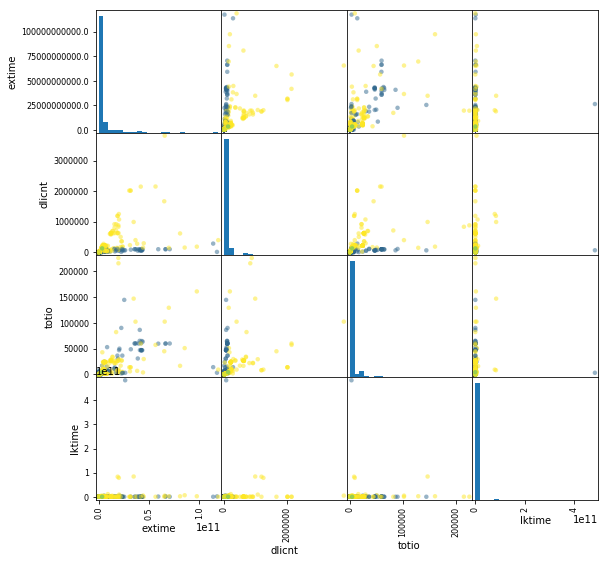

In [3]:
# plotting a scatter matrix
from matplotlib import cm
X = dliapps[['extime', 'dlicnt', 'totio', 'lktime']]
X = X.astype(np.float)
y = dliapps['access']

scatter = pd.plotting.scatter_matrix(X, c=y, marker = 'o', s=20, hist_kwds={'bins':25}, figsize=(9,9))

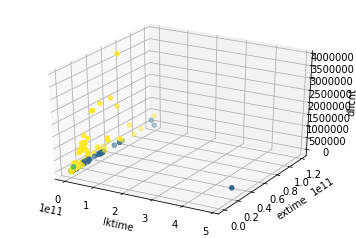

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# make a 3d scatter plot
ax.scatter(X['lktime'], X['extime'], X['dlicnt'], c=y) 
ax.set_xlabel('lktime')
ax.set_ylabel('extime')
ax.set_zlabel('dlicnt');

In [5]:
dliapps[dliapps['lktime'] == (dliapps['lktime'].max())].iloc[0]

blob         b'\x07\xd7\xe2\xc2\xc8\xd7\xd6\xf5\xf8@@@@@@@@...
type                                                        07
subtype                                                     d7
sequence                                              17488800
tod                                       15340811792902484364
datetime                            2018-09-07 13:22:59.126583
psb                                                   PSBHPO58
tran                                                          
extime                                             26299823421
ccode                                                        0
job                                                   HPO6000U
step                                                  STPRRC00
dlicnt                                                   62160
vsamrio                                                   1559
vsamwio                                                   1629
osamrio                                                

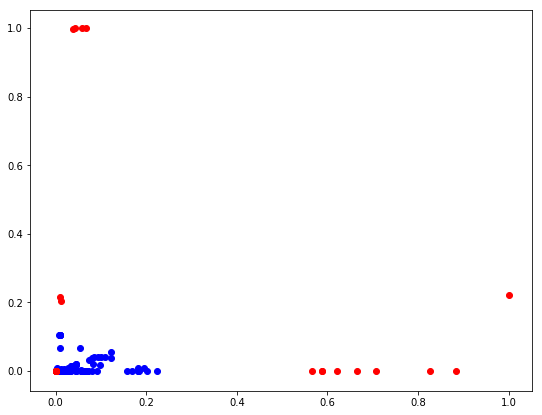

In [6]:
from sklearn import preprocessing
from sklearn import svm
from scipy import stats
import numpy as np

f1 = np.array(dliapps['extime'] / dliapps['dlicnt']).astype(float)
f2 = np.array(dliapps['totio'] / dliapps['dlicnt']).astype(float)
#f1 = dliapps['totio'].values
#f2 = dliapps['dlicnt'].values
X = np.transpose((f1, f2))
X = preprocessing.MinMaxScaler().fit_transform((X))

# Detect the outliers
clf = svm.OneClassSVM(kernel="rbf", nu=0.05)
clf.fit(X)
y_pred = clf.predict(X)

# Separate outliers from "normal" ones
gX = X[y_pred == 1]
bX = X[y_pred == -1]

# Show me
plt.figure(figsize=(9, 7))
plt.scatter(gX[:,0], gX[:,1], c='blue')
plt.scatter(bX[:,0], bX[:,1], c='red')
